In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def smooth(x, window_len=11, window="hanning"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len, "d")
    else:
        w = eval("np." + window + "(window_len)")

    # y = np.convolve(s, w / w.sum(), mode="same")
    y = signal.convolve(s, w/w.sum(), mode='same')

    return y

In [3]:
# rel_path = "Labs/lab_11122019/"
rel_path = "Labs/muon_271119/Run1/"
df = pd.read_csv(rel_path + 'ch1_test.csv', header=None)
f = open(rel_path + "event_information.log", "r")
info = f.readlines()
n_events = int(info[0].split()[-1])
n_per_event = int(info[1].split()[-1])

In [4]:
raw_data = df.values[0].flatten()
raw_data *= -1.0

In [5]:
timesteps = np.arange(0,n_per_event,1)
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((smoothed_data[0:n_per_event,np.newaxis], timesteps[:,np.newaxis]), axis=1)

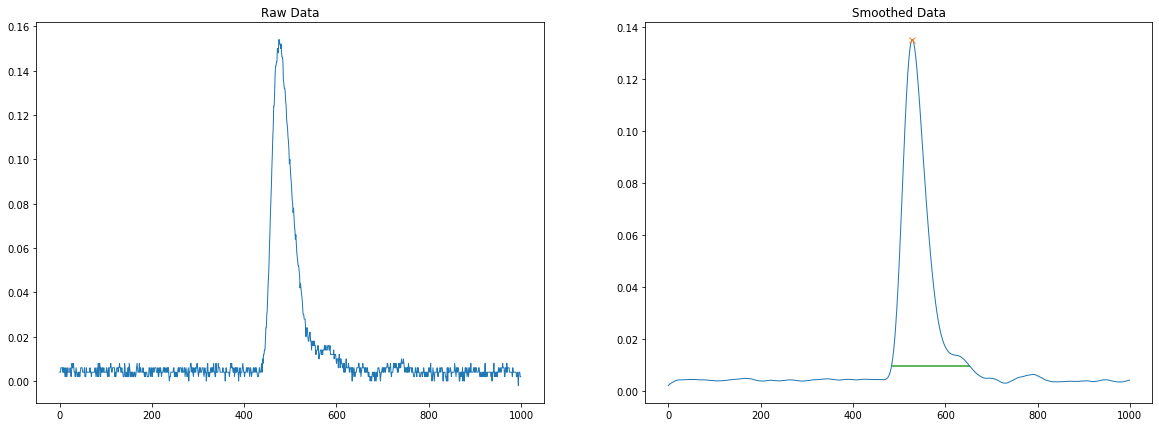

In [6]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
peaks, properties = signal.find_peaks(data[:,0], height=0.2*data[:,0].max())
results_w = signal.peak_widths(data[:,0], peaks, rel_height=0.95)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.plot(peaks, data[:,0][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [10]:
print('Peaks width: {wd}'.format(wd = results_w[1:][0] ))
for i in range(results_w[1:][0].size):
    print('Found peak in range: {rr1}, {rr2}'.format(rr1 = results_w[1:][i+1],rr2 = results_w[1:][i+2]))
print("Found peak at index {t} with amplitude: {amp}".format(t=peaks,amp=data[peaks,0]))

Peaks width: [0.00978352]
Found peak in range: [483.73766892], [652.70681818]
Found peak at index [529] with amplitude: [0.135296]


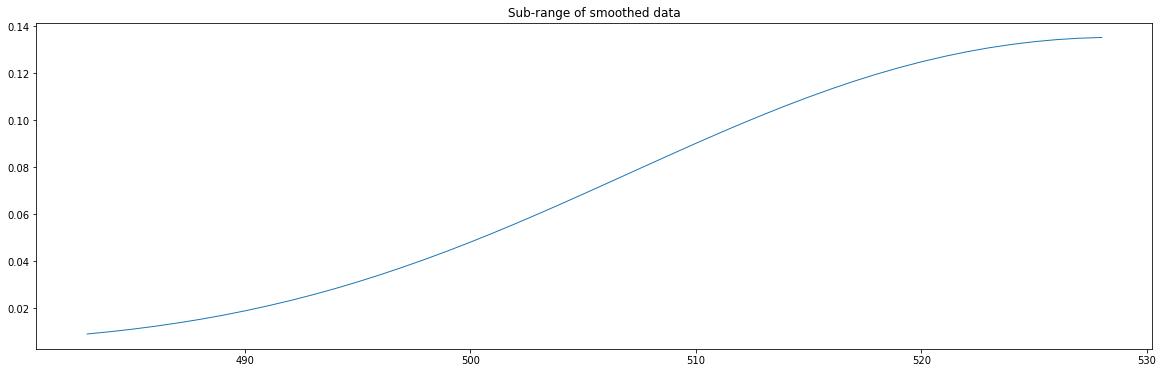

In [11]:
a = int(results_w[1:][1])
# ranged_sm_data = data[data[:,0]>=0.03*data[peaks,0].max()]
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

In [12]:
import iminuit
import probfit

In [13]:
# We want to speed things up with Cython
%load_ext Cython

In [14]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [15]:
iminuit.describe(sigmoid)

['x', 'p0', 'p1', 'p2', 'p3']

In [24]:
# unbinned_LH = probfit.UnbinnedLH(sigmoid, ranged_sm_data[:,0])
unbinned_LH = probfit.Chi2Regression(sigmoid, ranged_sm_data[:,1], ranged_sm_data[:,0])
minuit = iminuit.Minuit(unbinned_LH, p0=np.max(ranged_sm_data[:,0]), p1=ranged_sm_data[-1,1], p3=np.min(ranged_sm_data[:,0]), pedantic=False, print_level=3)
# minuit = iminuit.Minuit(unbinned_LH, p0=np.max(ranged_sm_data[:,0]), p1=ranged_sm_data[-1,1], p3=np.min(ranged_sm_data[:,0]),errordef=0.5,pedantic=False, print_level=0)

In [25]:
iminuit.describe(unbinned_LH)

['p0', 'p1', 'p2', 'p3']

In [26]:
minuit.migrad()

------------------------------------------------------------------
| FCN = 0.0009701               |     Ncalls=210 (210 total)     |
| EDM = 7.3E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 0.0009701               |     Ncalls=210 (210 total)     |
| EDM = 7.3E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.3    |    4.5    |            |            |         |         |       |
| 1 | p1   |    500    |    500    |            |            |         |         |       |
| 2 | p2   |   0.04    |   0.61    |            |            |         |         |       |
| 3 | p3   |   -0.07   |    1.70   |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [27]:
minuit.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.3    |    4.2    |            |            |         |         |       |
| 1 | p1   |    500    |    600    |            |            |         |         |       |
| 2 | p2   |   0.04    |   0.53    |            |            |         |         |       |
| 3 | p3   |   -0.07   |    0.89   |            |            |         |         |       |
------------------------------------------------------------------------------------------
--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.91 -0.95 -0.45 |
| p1 |  0.91  1.00 -0.84 -0.04 |
| p2 | -0.95 -0.84  1.00  0.51 |
| p3 | -0.45 -0.04  0.51  1.00 |
--------------------------------


------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.3    |    4.2    |            |            |         |         |       |
| 1 | p1   |    500    |    600    |            |            |         |         |       |
| 2 | p2   |   0.04    |   0.53    |            |            |         |         |       |
| 3 | p3   |   -0.07   |    0.89   |            |            |         |         |       |
------------------------------------------------------------------------------------------

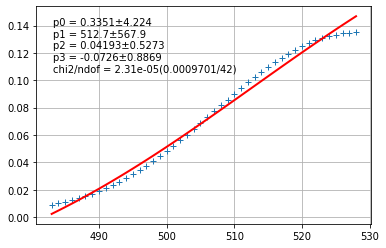

--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.91 -0.95 -0.45 |
| p1 |  0.91  1.00 -0.84 -0.04 |
| p2 | -0.95 -0.84  1.00  0.51 |
| p3 | -0.45 -0.04  0.51  1.00 |
--------------------------------


In [28]:
unbinned_LH.show(minuit)
# minuit.print_fmin()
minuit.print_matrix()

In [21]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 558ba79ccdc0>
  p0: 0.3071715959497435
  p1: 507.9317852260202
  p2: 0.0450317231715844
  p3: -0.07389105888272493
<ErrorView of Minuit at 558ba79ccdc0>
  p0: 3.9533057828784783
  p1: 578.5619313170306
  p2: 0.6201886818700231
  p3: 0.6381031490670442


/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=-649.192077
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=-569.390432
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=-489.588786
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=-170.382203
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=-10.778912
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=148.824380
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p1=308.427671
  """
/home/john/miniconda3/lib/python3.7/s

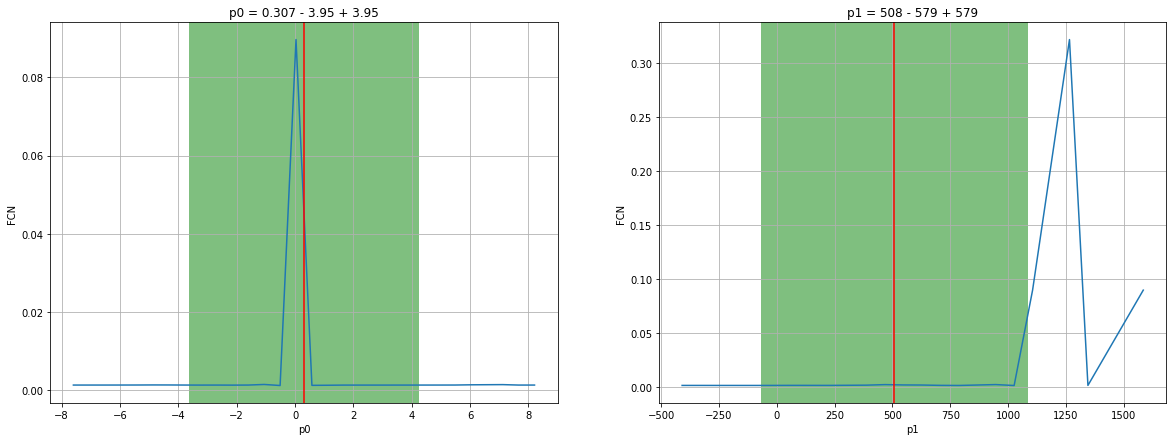

In [22]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=0.322173
  """


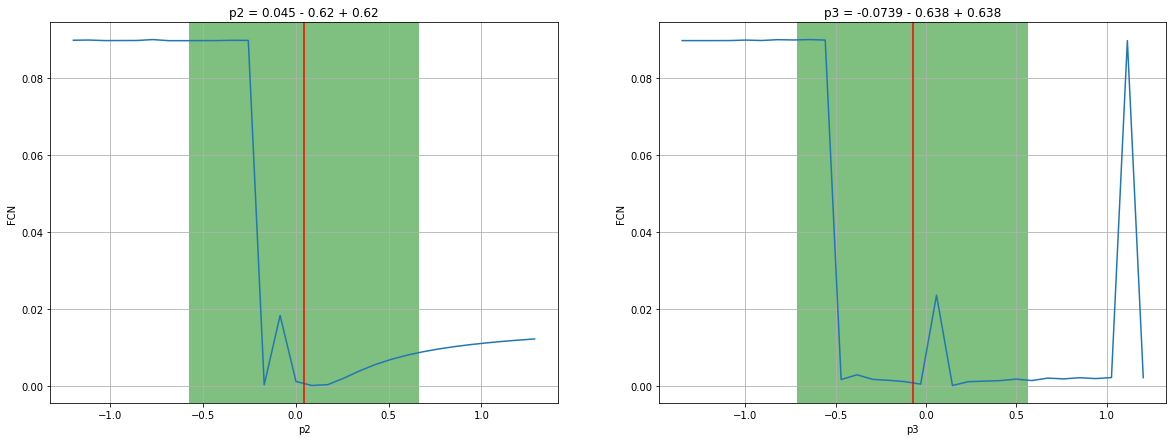

In [23]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()

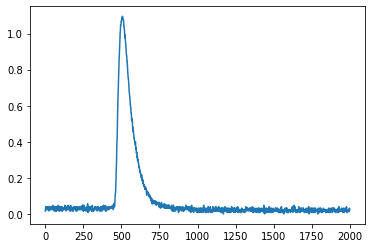

In [49]:
plt.plot(raw_data)

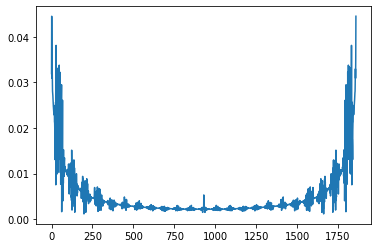

In [111]:
data_fft = np.fft.fft(data[:,0])
freq = (np.abs(data_fft[:len(data_fft)]))
plt.plot(freq[70:1930])

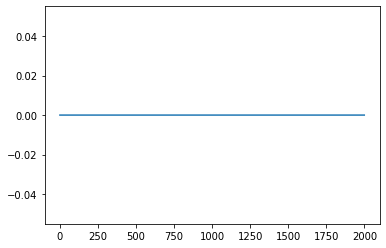

In [118]:
# filtered_freq = [f if (100 < index < 1900 and f > 1) else 0 for index, f in enumerate(freq)]
filtered_freq = [f if (index < 70 and index > 1930  and f>1) else 0 for index, f in enumerate(freq)]
plt.plot(filtered_freq)

/home/john/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


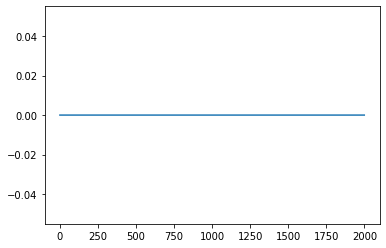

In [119]:
recovered_signal = np.fft.ifft(filtered_freq)
plt.plot(recovered_signal)

0.06499840000000001